# On the $ \gamma$ of Focal Loss (Middle Level Unbalance)


## 1. Basic Imports

In [1]:
import os
import time
import os.path as osp

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms
import torchvision
import random

import matplotlib.pyplot as plt
from PIL import Image

from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from collections import defaultdict

### 1.1 Hyperparameters

In [2]:
# random seed
SEED = 1 
NUM_CLASS = 10

# Training
BATCH_SIZE = 128
NUM_EPOCHS = 30
EVAL_INTERVAL=1
SAVE_DIR = './log'

# Optimizer
LEARNING_RATE = 1e-1
MOMENTUM = 0.9
STEP=5
GAMMA=0.5

## confusion matrix
confusion_ce = np.zeros((NUM_CLASS, NUM_CLASS))
confusion_l1 = np.zeros((NUM_CLASS, NUM_CLASS))
confusion_focal2 = np.zeros((NUM_CLASS, NUM_CLASS))
confusion_focal05 = np.zeros((NUM_CLASS, NUM_CLASS))

### 1.2 Device

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


### 1.3 Dataset


In [4]:
# cifar10 transform
transform_cifar10_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_cifar10_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_set = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform_cifar10_train)


test_set = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform_cifar10_test)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Files already downloaded and verified
Files already downloaded and verified


### 1.4 Creating an Unbalanced Training Set

In [5]:

samples_per_class = {
    0: 4000,
    1: 3500,
    2: 300,
    3: 500,
    4: 200,
    5: 100,
    6: 500,
    7: 200,
    8: 250,
    9: 100
}



samples_grouped_by_class = defaultdict(list)
for sample in train_set:
    label = sample[1]
    samples_grouped_by_class[label].append(sample)


selected_samples = []
for label, count in samples_per_class.items():
    selected_samples.extend(random.sample(samples_grouped_by_class[label], count))

train_set = selected_samples

train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

## 2. Model

## 2.1 Define the Neural Network

In [6]:
## define a model which has a softmax layer as the last layer, which is significant when considering L1 Loss and Focal Loss

class ConvNet_DIY(nn.Module):
    def __init__(self):
        super(ConvNet_DIY, self).__init__()
        
        # First block
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2, 2)
        
        # Second block
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(32 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        
        x = x.view(-1, 32 * 8 * 8)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x) 
        x = nn.Softmax(dim=1)(x) 
        return x


### 2.2 Define the Loss Functions and train_batch, testing_batch

In [7]:
# Define Focal Loss

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        
        eps = 1e-6
        probs = inputs.clamp(eps, 1. - eps)
        
        # calculate the loss of each class
        class_loss = -targets * torch.log(probs) * self.alpha * (1 - probs)**self.gamma
        
        # sum up
        loss = class_loss.sum(dim=1)

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss


In [8]:
##################### Define the 4 required Loss Functions##################
FocalLoss_05 = FocalLoss(gamma=0.5)
FocalLoss_1 = FocalLoss(gamma=1)
FocalLoss_2 = FocalLoss(gamma=2)
FocalLoss_3 = FocalLoss(gamma=3)
FocalLoss_4 = FocalLoss(gamma=4)
FocalLoss_5 = FocalLoss(gamma=5)
###############################################################

In [9]:
def train_batch(model, image, target, loss_fn):
    """
    Perform one training batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to train.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.
        loss_fn (torch.nn.Module, optional): Loss function to compute the loss.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated by the defined loss function.
    """
    
    output = model(image) 
    loss = loss_fn(output, target)

    return output, loss

In [10]:
def test_batch(model, image, target, loss_fn):
    """
    Perform one testing batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to evaluate.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated for the batch.
    """

    ##################### Write your answer here ##################
    output = model(image) 
    loss = loss_fn(output, target)
    ###############################################################

    return output, loss

In [11]:
## to adjust "target" to one-hot vector

def to_one_hot(targets, num_classes):
    one_hot = torch.zeros(targets.size(0), num_classes).to(targets.device)
    one_hot.scatter_(1, targets.unsqueeze(1), 1.)
    return one_hot

## 3 On the choice of $\gamma$

### 3.1 Focal Loss with $\gamma$ = 2

In [12]:
## initial the model for Focal Loss

model = ConvNet_DIY()

model.to(device)

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE/10, momentum=MOMENTUM)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

In [13]:
training_loss_Focal2 = []
training_acc_Focal2 = []
testing_loss_Focal2 = []
testing_acc_Focal2 = []

all_targets = []
all_preds = []


for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)
        target_one_hot = to_one_hot(target, NUM_CLASS)

        # train model
        outputs, loss = train_batch(model, image, target_one_hot, FocalLoss_2)
        _, preds = torch.max(outputs, 1)

        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    training_loss_Focal2.append(epoch_loss)
    training_acc_Focal2.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
    scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)
            target_one_hot = to_one_hot(target, NUM_CLASS)

            # test model
            outputs, loss = test_batch(model, image, target_one_hot, FocalLoss_2)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)
            
            all_targets.extend(target.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        testing_loss_Focal2.append(val_loss)
        testing_acc_Focal2.append(val_acc.cpu().detach().numpy())

        # save the model in last epoch
        if (epoch +1) == NUM_EPOCHS:
            
            state_Focal2 = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state_Focal2, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))

Epoch: 1/30 Train Loss: 0.0064 Acc: 0.5954
Begin test......
Test Loss: 0.0150 Acc: 0.2208
Epoch: 2/30 Train Loss: 0.0047 Acc: 0.6752
Begin test......
Test Loss: 0.0128 Acc: 0.2897
Epoch: 3/30 Train Loss: 0.0041 Acc: 0.7081
Begin test......
Test Loss: 0.0123 Acc: 0.3107
Epoch: 4/30 Train Loss: 0.0038 Acc: 0.7237
Begin test......
Test Loss: 0.0112 Acc: 0.3442
Epoch: 5/30 Train Loss: 0.0033 Acc: 0.7559
Begin test......
Test Loss: 0.0098 Acc: 0.3920
Epoch: 6/30 Train Loss: 0.0028 Acc: 0.7865
Begin test......
Test Loss: 0.0103 Acc: 0.3676
Epoch: 7/30 Train Loss: 0.0026 Acc: 0.7950
Begin test......
Test Loss: 0.0109 Acc: 0.3604
Epoch: 8/30 Train Loss: 0.0025 Acc: 0.8078
Begin test......
Test Loss: 0.0100 Acc: 0.3993
Epoch: 9/30 Train Loss: 0.0024 Acc: 0.8127
Begin test......
Test Loss: 0.0099 Acc: 0.4121
Epoch: 10/30 Train Loss: 0.0022 Acc: 0.8234
Begin test......
Test Loss: 0.0098 Acc: 0.4157
Epoch: 11/30 Train Loss: 0.0019 Acc: 0.8447
Begin test......
Test Loss: 0.0099 Acc: 0.4217
Epoch: 1

In [14]:
confusion_focal2 = confusion_matrix(all_targets, all_preds, labels=range(NUM_CLASS))
precision_focal2, recall_focal2, f1_focal2, _focal2 = precision_recall_fscore_support(all_targets, all_preds, labels=range(NUM_CLASS), average=None, zero_division=1)
macro_precision_focal2 = np.mean(precision_focal2)
macro_recall_focal2 = np.mean(recall_focal2)
macro_f1_focal2 = np.mean(f1_focal2)
micro_precision_focal2, micro_recall_focal2, micro_f1_focal2, _focal2 = precision_recall_fscore_support(all_targets, all_preds, labels=range(NUM_CLASS), average='micro')

print(f'Macro Precision: {macro_precision_focal2:.4f} Macro Recall: {macro_recall_focal2:.4f} Macro F1: {macro_f1_focal2:.4f}')
print(f'Micro Precision: {micro_precision_focal2:.4f} Micro Recall: {micro_recall_focal2:.4f} Micro F1: {micro_f1_focal2:.4f}')

Macro Precision: 0.5382 Macro Recall: 0.4048 Macro F1: 0.3549
Micro Precision: 0.4048 Micro Recall: 0.4048 Micro F1: 0.4048


### 3.2 Focal Loss with $\gamma = 0.5$

In [15]:
## initial the model for Focal Loss

model = ConvNet_DIY()
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE/10, momentum=MOMENTUM)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

In [16]:
training_loss_Focal05 = []
training_acc_Focal05 = []
testing_loss_Focal05 = []
testing_acc_Focal05 = []

all_targets = []
all_preds = []


for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)
        target_one_hot = to_one_hot(target, NUM_CLASS)

        # train model
        outputs, loss = train_batch(model, image, target_one_hot, FocalLoss_05)
        _, preds = torch.max(outputs, 1)

        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    training_loss_Focal05.append(epoch_loss)
    training_acc_Focal05.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
    scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)
            target_one_hot = to_one_hot(target, NUM_CLASS)

            # test model
            outputs, loss = test_batch(model, image, target_one_hot, FocalLoss_05)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)
            
            all_targets.extend(target.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        testing_loss_Focal05.append(val_loss)
        testing_acc_Focal05.append(val_acc.cpu().detach().numpy())

        # save the model in last epoch
        if (epoch +1) == NUM_EPOCHS:
            
            state_Focal05 = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state_Focal05, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))

Epoch: 1/30 Train Loss: 0.0086 Acc: 0.5996
Begin test......
Test Loss: 0.0184 Acc: 0.2145
Epoch: 2/30 Train Loss: 0.0066 Acc: 0.6810
Begin test......
Test Loss: 0.0157 Acc: 0.2938
Epoch: 3/30 Train Loss: 0.0058 Acc: 0.7181
Begin test......
Test Loss: 0.0163 Acc: 0.2875
Epoch: 4/30 Train Loss: 0.0053 Acc: 0.7432
Begin test......
Test Loss: 0.0152 Acc: 0.3271
Epoch: 5/30 Train Loss: 0.0049 Acc: 0.7608
Begin test......
Test Loss: 0.0151 Acc: 0.3301
Epoch: 6/30 Train Loss: 0.0042 Acc: 0.7953
Begin test......
Test Loss: 0.0136 Acc: 0.3719
Epoch: 7/30 Train Loss: 0.0040 Acc: 0.8037
Begin test......
Test Loss: 0.0139 Acc: 0.3677
Epoch: 8/30 Train Loss: 0.0037 Acc: 0.8150
Begin test......
Test Loss: 0.0129 Acc: 0.3866
Epoch: 9/30 Train Loss: 0.0035 Acc: 0.8265
Begin test......
Test Loss: 0.0136 Acc: 0.3900
Epoch: 10/30 Train Loss: 0.0034 Acc: 0.8269
Begin test......
Test Loss: 0.0139 Acc: 0.3898
Epoch: 11/30 Train Loss: 0.0030 Acc: 0.8530
Begin test......
Test Loss: 0.0136 Acc: 0.4105
Epoch: 1

In [17]:
confusion_focal05 = confusion_matrix(all_targets, all_preds, labels=range(NUM_CLASS))
precision_focal05, recall_focal05, f1_focal05, _focal05 = precision_recall_fscore_support(all_targets, all_preds, labels=range(NUM_CLASS), average=None, zero_division=1)
macro_precision_focal05 = np.mean(precision_focal05)
macro_recall_focal05 = np.mean(recall_focal05)
macro_f1_focal05 = np.mean(f1_focal05)
micro_precision_focal05, micro_recall_focal05, micro_f1_focal05, _focal05 = precision_recall_fscore_support(all_targets, all_preds, labels=range(NUM_CLASS), average='micro')

print(f'Macro Precision: {macro_precision_focal05:.4f} Macro Recall: {macro_recall_focal05:.4f} Macro F1: {macro_f1_focal05:.4f}')
print(f'Micro Precision: {micro_precision_focal05:.4f} Micro Recall: {micro_recall_focal05:.4f} Micro F1: {micro_f1_focal05:.4f}')

Macro Precision: 0.5324 Macro Recall: 0.3965 Macro F1: 0.3414
Micro Precision: 0.3965 Micro Recall: 0.3965 Micro F1: 0.3965


### 3.3 Focal Loss with $\gamma = 1$

In [18]:
## initial the model for Focal Loss

model = ConvNet_DIY()
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE/10, momentum=MOMENTUM)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

In [19]:
training_loss_Focal1 = []
training_acc_Focal1 = []
testing_loss_Focal1 = []
testing_acc_Focal1 = []

all_targets = []
all_preds = []


for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)
        target_one_hot = to_one_hot(target, NUM_CLASS)

        # train model
        outputs, loss = train_batch(model, image, target_one_hot, FocalLoss_1)
        _, preds = torch.max(outputs, 1)

        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    training_loss_Focal1.append(epoch_loss)
    training_acc_Focal1.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
    scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)
            target_one_hot = to_one_hot(target, NUM_CLASS)

            # test model
            outputs, loss = test_batch(model, image, target_one_hot, FocalLoss_1)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)
            
            all_targets.extend(target.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        testing_loss_Focal1.append(val_loss)
        testing_acc_Focal1.append(val_acc.cpu().detach().numpy())

        # save the model in last epoch
        if (epoch +1) == NUM_EPOCHS:
            
            state_Focal1 = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state_Focal1, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))

Epoch: 1/30 Train Loss: 0.0077 Acc: 0.6009
Begin test......
Test Loss: 0.0189 Acc: 0.2108
Epoch: 2/30 Train Loss: 0.0058 Acc: 0.6820
Begin test......
Test Loss: 0.0176 Acc: 0.2387
Epoch: 3/30 Train Loss: 0.0051 Acc: 0.7119
Begin test......
Test Loss: 0.0161 Acc: 0.2853
Epoch: 4/30 Train Loss: 0.0046 Acc: 0.7460
Begin test......
Test Loss: 0.0138 Acc: 0.3580
Epoch: 5/30 Train Loss: 0.0043 Acc: 0.7595
Begin test......
Test Loss: 0.0118 Acc: 0.3877
Epoch: 6/30 Train Loss: 0.0037 Acc: 0.7868
Begin test......
Test Loss: 0.0141 Acc: 0.3373
Epoch: 7/30 Train Loss: 0.0034 Acc: 0.8059
Begin test......
Test Loss: 0.0135 Acc: 0.3579
Epoch: 8/30 Train Loss: 0.0032 Acc: 0.8153
Begin test......
Test Loss: 0.0123 Acc: 0.4078
Epoch: 9/30 Train Loss: 0.0030 Acc: 0.8229
Begin test......
Test Loss: 0.0128 Acc: 0.3879
Epoch: 10/30 Train Loss: 0.0029 Acc: 0.8284
Begin test......
Test Loss: 0.0124 Acc: 0.4040
Epoch: 11/30 Train Loss: 0.0025 Acc: 0.8507
Begin test......
Test Loss: 0.0117 Acc: 0.4300
Epoch: 1

In [20]:
confusion_focal1 = confusion_matrix(all_targets, all_preds, labels=range(NUM_CLASS))
precision_focal1, recall_focal1, f1_focal1, _focal1 = precision_recall_fscore_support(all_targets, all_preds, labels=range(NUM_CLASS), average=None, zero_division=1)
macro_precision_focal1 = np.mean(precision_focal1)
macro_recall_focal1 = np.mean(recall_focal1)
macro_f1_focal1 = np.mean(f1_focal1)
micro_precision_focal1, micro_recall_focal1, micro_f1_focal1, _focal1 = precision_recall_fscore_support(all_targets, all_preds, labels=range(NUM_CLASS), average='micro')

print(f'Macro Precision: {macro_precision_focal1:.4f} Macro Recall: {macro_recall_focal1:.4f} Macro F1: {macro_f1_focal1:.4f}')
print(f'Micro Precision: {micro_precision_focal1:.4f} Micro Recall: {micro_recall_focal1:.4f} Micro F1: {micro_f1_focal1:.4f}')

Macro Precision: 0.5334 Macro Recall: 0.3996 Macro F1: 0.3479
Micro Precision: 0.3996 Micro Recall: 0.3996 Micro F1: 0.3996


### 3.4 Focal Loss with $\gamma = 3$

In [21]:
## initial the model for Focal Loss

model = ConvNet_DIY()
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE/10, momentum=MOMENTUM)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

In [22]:
training_loss_Focal3 = []
training_acc_Focal3 = []
testing_loss_Focal3 = []
testing_acc_Focal3 = []

all_targets = []
all_preds = []


for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)
        target_one_hot = to_one_hot(target, NUM_CLASS)

        # train model
        outputs, loss = train_batch(model, image, target_one_hot, FocalLoss_3)
        _, preds = torch.max(outputs, 1)

        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    training_loss_Focal3.append(epoch_loss)
    training_acc_Focal3.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
    scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)
            target_one_hot = to_one_hot(target, NUM_CLASS)

            # test model
            outputs, loss = test_batch(model, image, target_one_hot, FocalLoss_3)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)
            
            all_targets.extend(target.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        testing_loss_Focal3.append(val_loss)
        testing_acc_Focal3.append(val_acc.cpu().detach().numpy())

        # save the model in last epoch
        if (epoch +1) == NUM_EPOCHS:
            
            state_Focal3 = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state_Focal3, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))

Epoch: 1/30 Train Loss: 0.0055 Acc: 0.5802
Begin test......
Test Loss: 0.0141 Acc: 0.2198
Epoch: 2/30 Train Loss: 0.0040 Acc: 0.6762
Begin test......
Test Loss: 0.0123 Acc: 0.2451
Epoch: 3/30 Train Loss: 0.0034 Acc: 0.7070
Begin test......
Test Loss: 0.0108 Acc: 0.3093
Epoch: 4/30 Train Loss: 0.0031 Acc: 0.7258
Begin test......
Test Loss: 0.0123 Acc: 0.2775
Epoch: 5/30 Train Loss: 0.0028 Acc: 0.7422
Begin test......
Test Loss: 0.0094 Acc: 0.3640
Epoch: 6/30 Train Loss: 0.0023 Acc: 0.7790
Begin test......
Test Loss: 0.0082 Acc: 0.4064
Epoch: 7/30 Train Loss: 0.0022 Acc: 0.7895
Begin test......
Test Loss: 0.0087 Acc: 0.3986
Epoch: 8/30 Train Loss: 0.0021 Acc: 0.8004
Begin test......
Test Loss: 0.0081 Acc: 0.4116
Epoch: 9/30 Train Loss: 0.0019 Acc: 0.8085
Begin test......
Test Loss: 0.0090 Acc: 0.3944
Epoch: 10/30 Train Loss: 0.0018 Acc: 0.8162
Begin test......
Test Loss: 0.0086 Acc: 0.4002
Epoch: 11/30 Train Loss: 0.0016 Acc: 0.8408
Begin test......
Test Loss: 0.0085 Acc: 0.4168
Epoch: 1

In [23]:
confusion_focal3 = confusion_matrix(all_targets, all_preds, labels=range(NUM_CLASS))
precision_focal3, recall_focal3, f1_focal3, _focal3 = precision_recall_fscore_support(all_targets, all_preds, labels=range(NUM_CLASS), average=None, zero_division=1)
macro_precision_focal3 = np.mean(precision_focal3)
macro_recall_focal3 = np.mean(recall_focal3)
macro_f1_focal3 = np.mean(f1_focal3)
micro_precision_focal3, micro_recall_focal3, micro_f1_focal3, _focal3 = precision_recall_fscore_support(all_targets, all_preds, labels=range(NUM_CLASS), average='micro')

print(f'Macro Precision: {macro_precision_focal3:.4f} Macro Recall: {macro_recall_focal3:.4f} Macro F1: {macro_f1_focal3:.4f}')
print(f'Micro Precision: {micro_precision_focal3:.4f} Micro Recall: {micro_recall_focal3:.4f} Micro F1: {micro_f1_focal3:.4f}')

Macro Precision: 0.5259 Macro Recall: 0.3985 Macro F1: 0.3520
Micro Precision: 0.3985 Micro Recall: 0.3985 Micro F1: 0.3985


### 3.5 Focal Loss with $\gamma = 4$

In [24]:
## initial the model for Focal Loss

model = ConvNet_DIY()
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE/10, momentum=MOMENTUM)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

In [25]:
training_loss_Focal4 = []
training_acc_Focal4 = []
testing_loss_Focal4 = []
testing_acc_Focal4 = []

all_targets = []
all_preds = []


for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)
        target_one_hot = to_one_hot(target, NUM_CLASS)

        # train model
        outputs, loss = train_batch(model, image, target_one_hot, FocalLoss_4)
        _, preds = torch.max(outputs, 1)

        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    training_loss_Focal4.append(epoch_loss)
    training_acc_Focal4.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
    scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)
            target_one_hot = to_one_hot(target, NUM_CLASS)

            # test model
            outputs, loss = test_batch(model, image, target_one_hot, FocalLoss_4)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)
            
            all_targets.extend(target.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        testing_loss_Focal4.append(val_loss)
        testing_acc_Focal4.append(val_acc.cpu().detach().numpy())

        # save the model in last epoch
        if (epoch +1) == NUM_EPOCHS:
            
            state_Focal4 = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state_Focal4, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))

Epoch: 1/30 Train Loss: 0.0048 Acc: 0.5905
Begin test......
Test Loss: 0.0117 Acc: 0.1943
Epoch: 2/30 Train Loss: 0.0034 Acc: 0.6559
Begin test......
Test Loss: 0.0099 Acc: 0.3051
Epoch: 3/30 Train Loss: 0.0029 Acc: 0.6904
Begin test......
Test Loss: 0.0085 Acc: 0.3355
Epoch: 4/30 Train Loss: 0.0026 Acc: 0.7204
Begin test......
Test Loss: 0.0087 Acc: 0.3382
Epoch: 5/30 Train Loss: 0.0024 Acc: 0.7341
Begin test......
Test Loss: 0.0089 Acc: 0.3472
Epoch: 6/30 Train Loss: 0.0021 Acc: 0.7530
Begin test......
Test Loss: 0.0078 Acc: 0.3998
Epoch: 7/30 Train Loss: 0.0019 Acc: 0.7684
Begin test......
Test Loss: 0.0081 Acc: 0.3832
Epoch: 8/30 Train Loss: 0.0018 Acc: 0.7799
Begin test......
Test Loss: 0.0075 Acc: 0.4006
Epoch: 9/30 Train Loss: 0.0017 Acc: 0.7845
Begin test......
Test Loss: 0.0087 Acc: 0.3778
Epoch: 10/30 Train Loss: 0.0015 Acc: 0.8009
Begin test......
Test Loss: 0.0075 Acc: 0.4159
Epoch: 11/30 Train Loss: 0.0014 Acc: 0.8156
Begin test......
Test Loss: 0.0080 Acc: 0.4017
Epoch: 1

In [26]:
confusion_focal4 = confusion_matrix(all_targets, all_preds, labels=range(NUM_CLASS))
precision_focal4, recall_focal4, f1_focal4, _focal4 = precision_recall_fscore_support(all_targets, all_preds, labels=range(NUM_CLASS), average=None, zero_division=1)
macro_precision_focal4 = np.mean(precision_focal4)
macro_recall_focal4 = np.mean(recall_focal4)
macro_f1_focal4 = np.mean(f1_focal4)
micro_precision_focal4, micro_recall_focal4, micro_f1_focal4, _focal4 = precision_recall_fscore_support(all_targets, all_preds, labels=range(NUM_CLASS), average='micro')

print(f'Macro Precision: {macro_precision_focal4:.4f} Macro Recall: {macro_recall_focal4:.4f} Macro F1: {macro_f1_focal4:.4f}')
print(f'Micro Precision: {micro_precision_focal4:.4f} Micro Recall: {micro_recall_focal4:.4f} Micro F1: {micro_f1_focal4:.4f}')

Macro Precision: 0.5314 Macro Recall: 0.3977 Macro F1: 0.3552
Micro Precision: 0.3977 Micro Recall: 0.3977 Micro F1: 0.3977


### 3.6 Focal Loss with $\gamma = 5$

In [27]:
## initial the model for Focal Loss

model = ConvNet_DIY()
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE/10, momentum=MOMENTUM)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

In [28]:
training_loss_Focal5 = []
training_acc_Focal5 = []
testing_loss_Focal5 = []
testing_acc_Focal5 = []

all_targets = []
all_preds = []


for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)
        target_one_hot = to_one_hot(target, NUM_CLASS)

        # train model
        outputs, loss = train_batch(model, image, target_one_hot, FocalLoss_5)
        _, preds = torch.max(outputs, 1)

        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    training_loss_Focal5.append(epoch_loss)
    training_acc_Focal5.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
    scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)
            target_one_hot = to_one_hot(target, NUM_CLASS)

            # test model
            outputs, loss = test_batch(model, image, target_one_hot, FocalLoss_5)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)
            
            all_targets.extend(target.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        testing_loss_Focal5.append(val_loss)
        testing_acc_Focal5.append(val_acc.cpu().detach().numpy())

        # save the model in last epoch
        if (epoch +1) == NUM_EPOCHS:
            
            state_Focal5 = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state_Focal5, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))

Epoch: 1/30 Train Loss: 0.0041 Acc: 0.5982
Begin test......
Test Loss: 0.0106 Acc: 0.2262
Epoch: 2/30 Train Loss: 0.0029 Acc: 0.6622
Begin test......
Test Loss: 0.0087 Acc: 0.2775
Epoch: 3/30 Train Loss: 0.0025 Acc: 0.6869
Begin test......
Test Loss: 0.0088 Acc: 0.3198
Epoch: 4/30 Train Loss: 0.0022 Acc: 0.7098
Begin test......
Test Loss: 0.0079 Acc: 0.3504
Epoch: 5/30 Train Loss: 0.0020 Acc: 0.7358
Begin test......
Test Loss: 0.0085 Acc: 0.3349
Epoch: 6/30 Train Loss: 0.0016 Acc: 0.7566
Begin test......
Test Loss: 0.0070 Acc: 0.3833
Epoch: 7/30 Train Loss: 0.0015 Acc: 0.7723
Begin test......
Test Loss: 0.0073 Acc: 0.3676
Epoch: 8/30 Train Loss: 0.0014 Acc: 0.7787
Begin test......
Test Loss: 0.0069 Acc: 0.3953
Epoch: 9/30 Train Loss: 0.0013 Acc: 0.7909
Begin test......
Test Loss: 0.0076 Acc: 0.3803
Epoch: 10/30 Train Loss: 0.0012 Acc: 0.7945
Begin test......
Test Loss: 0.0065 Acc: 0.4234
Epoch: 11/30 Train Loss: 0.0010 Acc: 0.8168
Begin test......
Test Loss: 0.0071 Acc: 0.4087
Epoch: 1

In [29]:
confusion_focal5 = confusion_matrix(all_targets, all_preds, labels=range(NUM_CLASS))
precision_focal5, recall_focal5, f1_focal5, _focal5 = precision_recall_fscore_support(all_targets, all_preds, labels=range(NUM_CLASS), average=None, zero_division=1)
macro_precision_focal5 = np.mean(precision_focal5)
macro_recall_focal5 = np.mean(recall_focal5)
macro_f1_focal5 = np.mean(f1_focal5)
micro_precision_focal5, micro_recall_focal5, micro_f1_focal5, _focal5 = precision_recall_fscore_support(all_targets, all_preds, labels=range(NUM_CLASS), average='micro')

print(f'Macro Precision: {macro_precision_focal5:.4f} Macro Recall: {macro_recall_focal5:.4f} Macro F1: {macro_f1_focal5:.4f}')
print(f'Micro Precision: {micro_precision_focal5:.4f} Micro Recall: {micro_recall_focal5:.4f} Micro F1: {micro_f1_focal5:.4f}')

Macro Precision: 0.5415 Macro Recall: 0.3976 Macro F1: 0.3535
Micro Precision: 0.3977 Micro Recall: 0.3977 Micro F1: 0.3977


## 4. Comparision the Performance of Different Loss on Unbalanced Set

In [30]:
labels = ['Focal Loss γ=0.5', 'Focal Loss γ=1', 'Focal Loss γ=2', 'Focal Loss γ=3', 'Focal Loss γ=4', 'Focal Loss γ=5']

macro_precisions = [macro_precision_focal05, macro_precision_focal1, macro_precision_focal2, macro_precision_focal3, macro_precision_focal4, macro_precision_focal5]
macro_recalls = [macro_recall_focal05, macro_recall_focal1, macro_recall_focal2, macro_recall_focal3, macro_recall_focal4, macro_recall_focal5]
macro_f1s = [macro_f1_focal05, macro_f1_focal1, macro_f1_focal2, macro_f1_focal3, macro_f1_focal4, macro_f1_focal5]

micro_precisions = [micro_precision_focal05, micro_precision_focal1, micro_precision_focal2, micro_precision_focal3, micro_precision_focal4, micro_precision_focal5]
micro_recalls = [micro_recall_focal05, micro_recall_focal1, micro_recall_focal2, micro_recall_focal3, micro_recall_focal4, micro_recall_focal5]
micro_f1s = [micro_f1_focal05,micro_f1_focal1, micro_f1_focal2, micro_f1_focal3, micro_f1_focal4, micro_f1_focal5]

df = pd.DataFrame({
    'Loss Function': labels,
    'Macro Precision': macro_precisions,
    'Macro Recall': macro_recalls,
    'Macro F1': macro_f1s,
    'Micro Precision': micro_precisions,
    'Micro Recall': micro_recalls,
    'Micro F1': micro_f1s
})

# 显示表格
print(df)

      Loss Function  Macro Precision  Macro Recall  Macro F1  Micro Precision  \
0  Focal Loss γ=0.5         0.532364      0.396540  0.341366         0.396540   
1    Focal Loss γ=1         0.533369      0.399560  0.347868         0.399560   
2    Focal Loss γ=2         0.538163      0.404797  0.354852         0.404797   
3    Focal Loss γ=3         0.525883      0.398533  0.351958         0.398533   
4    Focal Loss γ=4         0.531450      0.397750  0.355249         0.397750   
5    Focal Loss γ=5         0.541537      0.397650  0.353524         0.397650   

   Micro Recall  Micro F1  
0      0.396540  0.396540  
1      0.399560  0.399560  
2      0.404797  0.404797  
3      0.398533  0.398533  
4      0.397750  0.397750  
5      0.397650  0.397650  


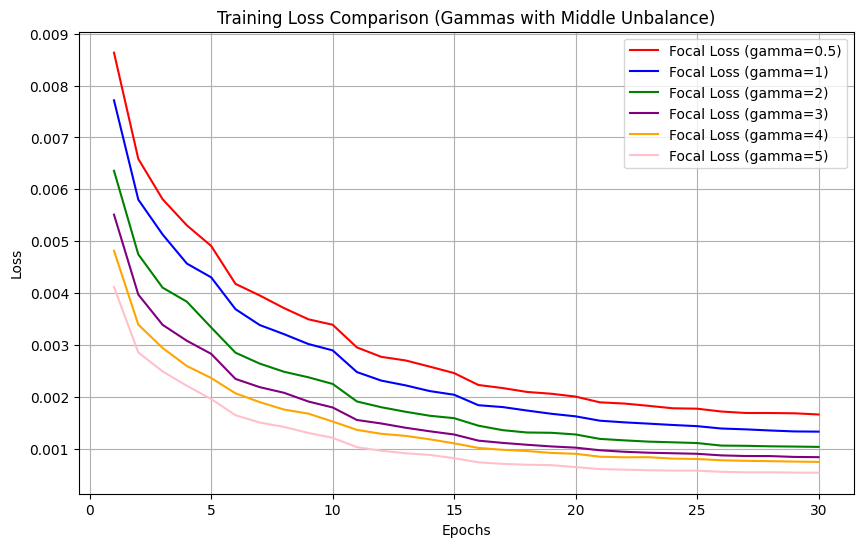

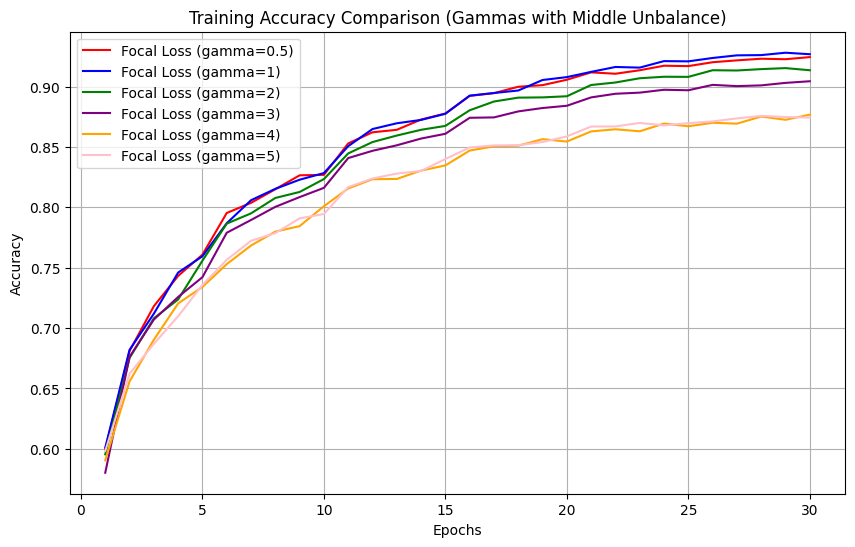

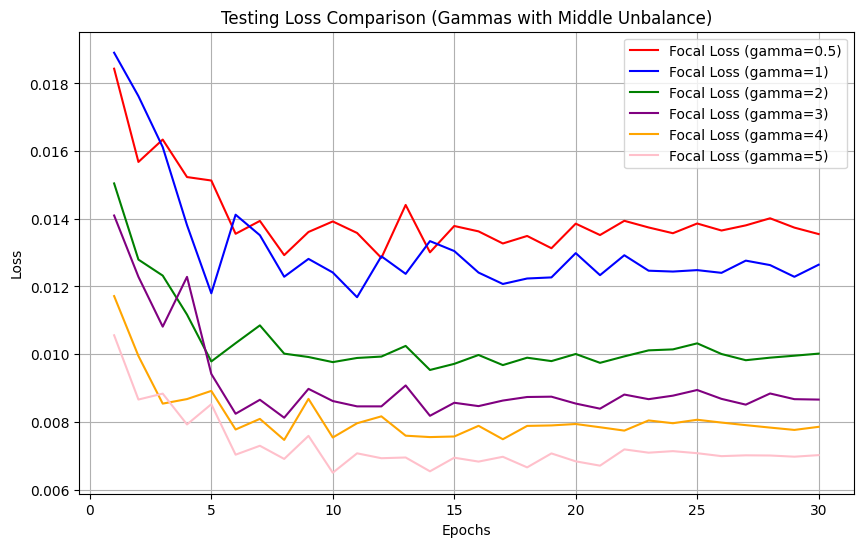

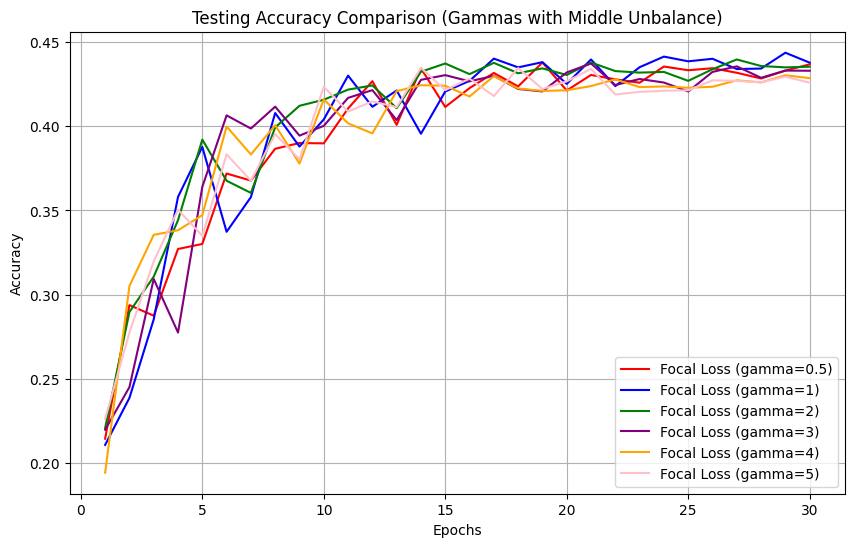

In [31]:
epochs = range(1, len(training_loss_Focal05) + 1)

# 训练损失对比图
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss_Focal05, label='Focal Loss (gamma=0.5)', color='red')
plt.plot(epochs, training_loss_Focal1, label='Focal Loss (gamma=1)', color='blue')
plt.plot(epochs, training_loss_Focal2, label='Focal Loss (gamma=2)', color='green')
plt.plot(epochs, training_loss_Focal3, label='Focal Loss (gamma=3)', color='purple')
plt.plot(epochs, training_loss_Focal4, label='Focal Loss (gamma=4)', color='orange')
plt.plot(epochs, training_loss_Focal5, label='Focal Loss (gamma=5)', color='pink')
plt.title('Training Loss Comparison (Gammas with Middle Unbalance)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('pic/training_loss_comparison_gamma_middle.png')
plt.show()

# 训练准确率对比图
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_acc_Focal05, label='Focal Loss (gamma=0.5)', color='red')
plt.plot(epochs, training_acc_Focal1, label='Focal Loss (gamma=1)', color='blue')
plt.plot(epochs, training_acc_Focal2, label='Focal Loss (gamma=2)', color='green')
plt.plot(epochs, training_acc_Focal3, label='Focal Loss (gamma=3)', color='purple')
plt.plot(epochs, training_acc_Focal4, label='Focal Loss (gamma=4)', color='orange')
plt.plot(epochs, training_acc_Focal5, label='Focal Loss (gamma=5)', color='pink')
plt.title('Training Accuracy Comparison (Gammas with Middle Unbalance)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('pic/training_accuracy_comparison_gamma_middle.png')
plt.show()

# 测试损失对比图
plt.figure(figsize=(10, 6))
plt.plot(epochs, testing_loss_Focal05, label='Focal Loss (gamma=0.5)', color='red')
plt.plot(epochs, testing_loss_Focal1, label='Focal Loss (gamma=1)', color='blue')
plt.plot(epochs, testing_loss_Focal2, label='Focal Loss (gamma=2)', color='green')
plt.plot(epochs, testing_loss_Focal3, label='Focal Loss (gamma=3)', color='purple')
plt.plot(epochs, testing_loss_Focal4, label='Focal Loss (gamma=4)', color='orange')
plt.plot(epochs, testing_loss_Focal5, label='Focal Loss (gamma=5)', color='pink')
plt.title('Testing Loss Comparison (Gammas with Middle Unbalance)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('pic/testing_loss_comparison_gamma_middle.png')
plt.show()

# 测试准确率对比图
plt.figure(figsize=(10, 6))
plt.plot(epochs, testing_acc_Focal05, label='Focal Loss (gamma=0.5)', color='red')
plt.plot(epochs, testing_acc_Focal1, label='Focal Loss (gamma=1)', color='blue')
plt.plot(epochs, testing_acc_Focal2, label='Focal Loss (gamma=2)', color='green')
plt.plot(epochs, testing_acc_Focal3, label='Focal Loss (gamma=3)', color='purple')
plt.plot(epochs, testing_acc_Focal4, label='Focal Loss (gamma=4)', color='orange')
plt.plot(epochs, testing_acc_Focal5, label='Focal Loss (gamma=5)', color='pink')
plt.title('Testing Accuracy Comparison (Gammas with Middle Unbalance)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('pic/testing_accuracy_comparison_gamma_middle.png')
plt.show()

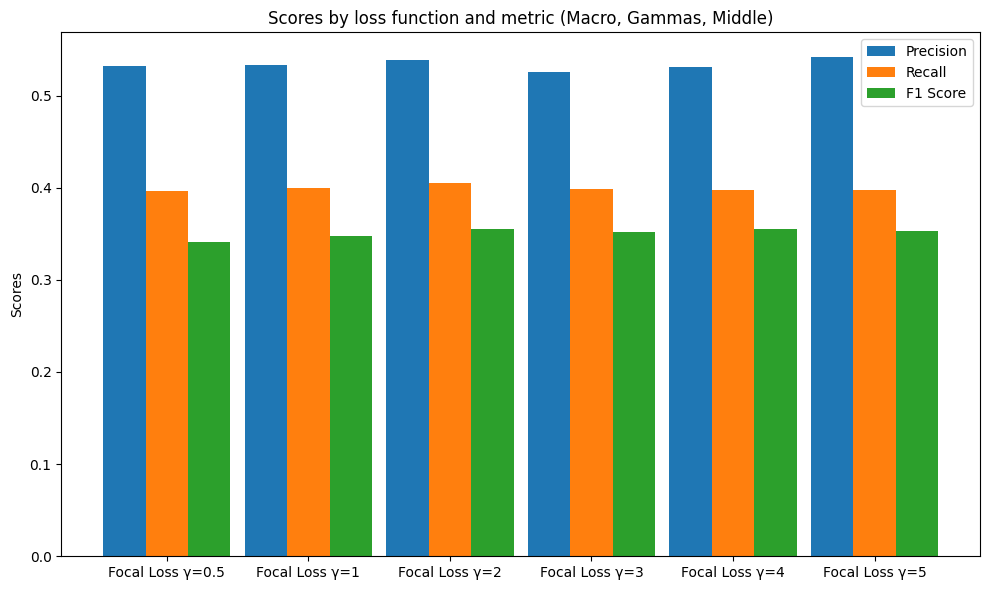

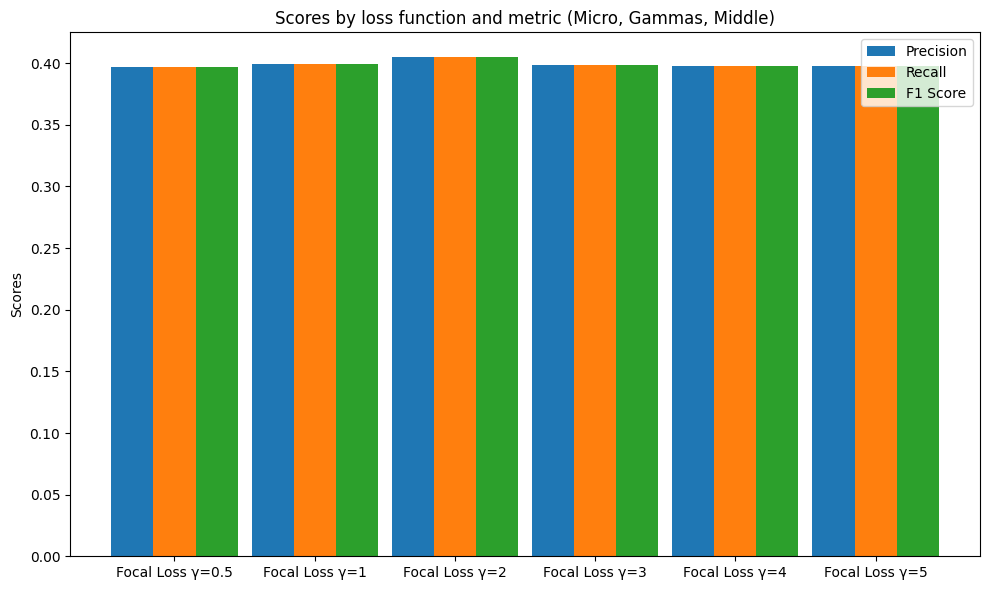

In [32]:
# Marco
x = np.arange(len(labels))
width = 0.3
fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width, macro_precisions, width, label='Precision')
rects2 = ax.bar(x, macro_recalls, width, label='Recall')
rects3 = ax.bar(x + width, macro_f1s, width, label='F1 Score')

ax.set_ylabel('Scores')
ax.set_title('Scores by loss function and metric (Macro, Gammas, Middle)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
plt.savefig('pic/macro_scores_gamma_middle.png')
plt.show()

# Micro
fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width, micro_precisions, width, label='Precision')
rects2 = ax.bar(x, micro_recalls, width, label='Recall')
rects3 = ax.bar(x + width, micro_f1s, width, label='F1 Score')

ax.set_ylabel('Scores')
ax.set_title('Scores by loss function and metric (Micro, Gammas, Middle)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
plt.savefig('pic/micro_scores_gamma_middle.png')
plt.show()

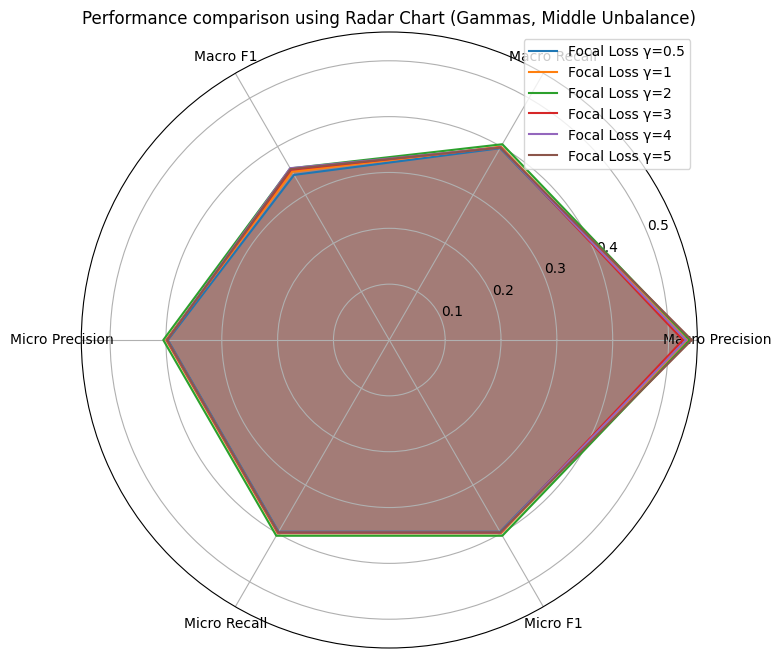

In [33]:
metrics = ['Macro Precision', 'Macro Recall', 'Macro F1', 'Micro Precision', 'Micro Recall', 'Micro F1']
values_list = [
    [macro_precision_focal05, macro_recall_focal05, macro_f1_focal05, micro_precision_focal05, micro_recall_focal05, micro_f1_focal05],
    [macro_precision_focal1, macro_recall_focal1, macro_f1_focal1, micro_precision_focal1, micro_recall_focal1, micro_f1_focal1],
    [macro_precision_focal2, macro_recall_focal2, macro_f1_focal2, micro_precision_focal2, micro_recall_focal2, micro_f1_focal2],
    [macro_precision_focal3, macro_recall_focal3, macro_f1_focal3, micro_precision_focal3, micro_recall_focal3, micro_f1_focal3],
    [macro_precision_focal4, macro_recall_focal4, macro_f1_focal4, micro_precision_focal4, micro_recall_focal4, micro_f1_focal4],
    [macro_precision_focal5, macro_recall_focal5, macro_f1_focal5, micro_precision_focal5, micro_recall_focal5, micro_f1_focal5],
]

# draw the Radar Chart
N = len(metrics)
theta = np.linspace(0, 2 * np.pi, N, endpoint=False)
theta = np.concatenate((theta, [theta[0]]))

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'polar'})

for values, label in zip(values_list, labels):
    values = np.concatenate((values, [values[0]]))  # Close the loop
    ax.plot(theta, values, label=label)
    ax.fill(theta, values, alpha=0.25)

ax.set_xticks(theta[:-1])
ax.set_xticklabels(metrics)
ax.set_title("Performance comparison using Radar Chart (Gammas, Middle Unbalance)")
ax.legend(loc='upper right')
plt.savefig('pic/radar_gamma_middle.png')
plt.show()

